The code/model is based on [this kernel](https://www.kaggle.com/tanlikesmath/fastai-starter-iwildcam-2019) and uses a pretrained DenseNet121, along with Mixup as implemented by the fastai library.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import json
import PIL.Image, PIL.ImageFile

PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

from fastai import *
from fastai.vision import *
from fastai.utils.mem import *

# Data Load

In [3]:
path = Path('/kaggle/input/iwildcam-2020-fgvc7')

debug =1
if debug:
    train_pct=0.04
else:
    train_pct=0.5
bs=32

In [4]:
!ls /kaggle/input/iwildcam-2020-fgvc7

iwildcam2020_megadetector_results.json	sample_submission.csv
iwildcam2020_test_information.json	test
iwildcam2020_train_annotations.json	train


In [5]:
with open(path/'iwildcam2020_train_annotations.json') as f:
    train_data = json.load(f)
    
with open(path/'iwildcam2020_test_information.json') as f:
    test_data = json.load(f)

In [6]:
train_data.keys()

dict_keys(['annotations', 'images', 'categories', 'info'])

In [7]:
print( '#train_data')
print()
for key in train_data.keys():
    print( 'length of', key, ':', len(train_data[key]) )
    if key != 'info':
        print( 'example:', train_data[key][0])
    else:
        print(train_data[key])
    print()

#train_data

length of annotations : 217959
example: {'count': 1, 'image_id': '96b00332-21bc-11ea-a13a-137349068a90', 'id': 'a292dd3c-21bc-11ea-a13a-137349068a90', 'category_id': 73}

length of images : 217959
example: {'seq_num_frames': 1, 'location': 267, 'datetime': '2013-08-08 11:45:00.000', 'id': '96b00332-21bc-11ea-a13a-137349068a90', 'frame_num': 1, 'seq_id': '96b004ea-21bc-11ea-a13a-137349068a90', 'width': 1795, 'height': 1222, 'file_name': '96b00332-21bc-11ea-a13a-137349068a90.jpg'}

length of categories : 267
example: {'count': 78981, 'id': 0, 'name': 'empty'}

length of info : 4
{'year': '2020', 'description': 'Train metadata for the iWildCam2020 challenge', 'version': 'V1_2_26_2020', 'contributor': 'WCS, Sara Beery, Eli Cole, Arvi Gjoka, Dan Morris, Siyu Yang'}



In [8]:
print( '#test_data')
print()
for key in test_data.keys():
    print( 'length of', key, ':', len(test_data[key]) )
    if key != 'info':
        print( 'example:', test_data[key][0])
    else:
        print(test_data[key])
    print()

#test_data

length of images : 62894
example: {'seq_num_frames': 1, 'location': 84, 'datetime': '2013-08-02 21:44:00.000', 'id': '88037cce-21bc-11ea-a13a-137349068a90', 'frame_num': 1, 'seq_id': '88037e90-21bc-11ea-a13a-137349068a90', 'width': 2771, 'height': 1779, 'file_name': '88037cce-21bc-11ea-a13a-137349068a90.jpg'}

length of categories : 267
example: {'count': 28078, 'id': 0, 'name': 'empty'}

length of info : 4
{'year': '2020', 'description': 'Test metadata for the iWildCam2020 challenge', 'version': 'V1_2_26_2020', 'contributor': 'WCS, Sara Beery, Eli Cole, Arvi Gjoka, Dan Morris, Siyu Yang'}



There is no annotations in test_data as we expect

# Data Parsing

In [9]:
df_train = pd.DataFrame.from_records(train_data['annotations'])
df_train

,count,image_id,id,category_id
0,1,96b00332-21bc-11ea-a13a-137349068a90,a292dd3c-21bc-11ea-a13a-137349068a90,73
1,1,879d74d8-21bc-11ea-a13a-137349068a90,a0afcfc0-21bc-11ea-a13a-137349068a90,4
2,1,9017f7aa-21bc-11ea-a13a-137349068a90,a306e9c0-21bc-11ea-a13a-137349068a90,227
3,1,90d93c58-21bc-11ea-a13a-137349068a90,9eed94c4-21bc-11ea-a13a-137349068a90,250
4,1,887cd0ec-21bc-11ea-a13a-137349068a90,a2a4dd7a-21bc-11ea-a13a-137349068a90,2
...,...,...,...,...
217954,1,8b7899a2-21bc-11ea-a13a-137349068a90,9b4c9de2-21bc-11ea-a13a-137349068a90,372
217955,1,958f609c-21bc-11ea-a13a-137349068a90,9a379740-21bc-11ea-a13a-137349068a90,372
217956,1,93bd2ede-21bc-11ea-a13a-137349068a90,9d0a3c0c-21bc-11ea-a13a-137349068a90,372
217957,1,8971956e-21bc-11ea-a13a-137349068a90,9fe5065a-21bc-11ea-a13a-137349068a90,372


In [10]:
df_train = pd.DataFrame.from_records(train_data['annotations'])
df_train

,count,image_id,id,category_id
0,1,96b00332-21bc-11ea-a13a-137349068a90,a292dd3c-21bc-11ea-a13a-137349068a90,73
1,1,879d74d8-21bc-11ea-a13a-137349068a90,a0afcfc0-21bc-11ea-a13a-137349068a90,4
2,1,9017f7aa-21bc-11ea-a13a-137349068a90,a306e9c0-21bc-11ea-a13a-137349068a90,227
3,1,90d93c58-21bc-11ea-a13a-137349068a90,9eed94c4-21bc-11ea-a13a-137349068a90,250
4,1,887cd0ec-21bc-11ea-a13a-137349068a90,a2a4dd7a-21bc-11ea-a13a-137349068a90,2
...,...,...,...,...
217954,1,8b7899a2-21bc-11ea-a13a-137349068a90,9b4c9de2-21bc-11ea-a13a-137349068a90,372
217955,1,958f609c-21bc-11ea-a13a-137349068a90,9a379740-21bc-11ea-a13a-137349068a90,372
217956,1,93bd2ede-21bc-11ea-a13a-137349068a90,9d0a3c0c-21bc-11ea-a13a-137349068a90,372
217957,1,8971956e-21bc-11ea-a13a-137349068a90,9fe5065a-21bc-11ea-a13a-137349068a90,372


Drop the row which has the loading problem with PIL

error occured with '896c1198-21bc-11ea-a13a-137349068a90', '8792549a-21bc-11ea-a13a-137349068a90', and so on

In [11]:
#df_image[df_image['id'] == '896c1198-21bc-11ea-a13a-137349068a90']
#df_image[df_image['id'] == '8792549a-21bc-11ea-a13a-137349068a90']
#df_image[df_image['id'] == '87022118-21bc-11ea-a13a-137349068a90']

#df_image[df_image['seq_id'] == '98a295ba-21bc-11ea-a13a-137349068a90']
#df_image[df_image['location'] == 537]['id'].values

These images match with same seq_id, '98a295ba-21bc-11ea-a13a-137349068a90', '99136c90-21bc-11ea-a13a-137349068a90'

and location 537

I dropped images from 537 location

In [12]:
df_image = pd.DataFrame.from_records(train_data['images'])

indices = []
#indices.append( df_train[ df_train['image_id'] == '896c1198-21bc-11ea-a13a-137349068a90' ].index )
#indices.append( df_train[ df_train['image_id'] == '8792549a-21bc-11ea-a13a-137349068a90' ].index )
for _id in df_image[df_image['location'] == 537]['id'].values:
    indices.append( df_train[ df_train['image_id'] == _id ].index )

for the_index in indices:
    df_train = df_train.drop(df_train.index[the_index])

There are some images have more than 1 count

In [13]:
df_train[df_train['count']>1]

,count,image_id,id,category_id
137,2,925d7012-21bc-11ea-a13a-137349068a90,9c996ce8-21bc-11ea-a13a-137349068a90,315
138,2,9191cafc-21bc-11ea-a13a-137349068a90,9a172802-21bc-11ea-a13a-137349068a90,315
139,2,968b51fe-21bc-11ea-a13a-137349068a90,a0d88906-21bc-11ea-a13a-137349068a90,315
140,2,890d6102-21bc-11ea-a13a-137349068a90,9d9271b2-21bc-11ea-a13a-137349068a90,315
141,2,9361ae06-21bc-11ea-a13a-137349068a90,9a9a26e4-21bc-11ea-a13a-137349068a90,315
...,...,...,...,...
217934,4,87a65f44-21bc-11ea-a13a-137349068a90,9aa602a2-21bc-11ea-a13a-137349068a90,372
217935,4,944d2eb2-21bc-11ea-a13a-137349068a90,a31b5b62-21bc-11ea-a13a-137349068a90,372
217936,4,8fe25bf4-21bc-11ea-a13a-137349068a90,a273c8f2-21bc-11ea-a13a-137349068a90,372
217937,4,8c59ae60-21bc-11ea-a13a-137349068a90,9e04eb02-21bc-11ea-a13a-137349068a90,372


In [14]:
df_test = pd.DataFrame.from_records(test_data['images'])
df_test

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name
0,1,84,2013-08-02 21:44:00.000,88037cce-21bc-11ea-a13a-137349068a90,1,88037e90-21bc-11ea-a13a-137349068a90,2771,1779,88037cce-21bc-11ea-a13a-137349068a90.jpg
1,1,84,2013-08-02 21:51:00.000,963e6b46-21bc-11ea-a13a-137349068a90,1,963e6cb8-21bc-11ea-a13a-137349068a90,2771,1779,963e6b46-21bc-11ea-a13a-137349068a90.jpg
2,1,548,2013-04-25 18:23:00.000,8a1b53ba-21bc-11ea-a13a-137349068a90,1,8a1b5554-21bc-11ea-a13a-137349068a90,2895,1865,8a1b53ba-21bc-11ea-a13a-137349068a90.jpg
3,1,181,2013-04-17 16:10:00.000,938c0d5e-21bc-11ea-a13a-137349068a90,1,938c0f02-21bc-11ea-a13a-137349068a90,2902,1818,938c0d5e-21bc-11ea-a13a-137349068a90.jpg
4,1,181,2013-04-20 03:11:00.000,95b9bd92-21bc-11ea-a13a-137349068a90,1,95b9be96-21bc-11ea-a13a-137349068a90,2212,1841,95b9bd92-21bc-11ea-a13a-137349068a90.jpg
...,...,...,...,...,...,...,...,...,...
62889,-1,5,2013-08-01 18:45:20.000,978d4224-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,978d4224-21bc-11ea-a13a-137349068a90.jpg
62890,-1,5,2013-08-01 18:45:21.000,8bd8cad4-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8bd8cad4-21bc-11ea-a13a-137349068a90.jpg
62891,-1,5,2013-08-01 18:45:22.000,8c894fc6-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,8c894fc6-21bc-11ea-a13a-137349068a90.jpg
62892,-1,5,2013-08-01 18:45:22.000,97bffbf6-21bc-11ea-a13a-137349068a90,-1,995a6da2-21bc-11ea-a13a-137349068a90,1280,1024,97bffbf6-21bc-11ea-a13a-137349068a90.jpg


In [15]:
df_test['frame_num'].value_counts()

-1      25139
 1       6355
 2       6276
 3       6271
 5       1956
        ...  
 659        1
 627        1
 595        1
 563        1
 783        1
Name: frame_num, Length: 973, dtype: int64

In [16]:
df_test = df_test.rename(columns={"id": "image_id"})

In [17]:
train, test = [ImageList.from_df(df, path=path, cols='image_id', folder=folder, suffix='.jpg') 
               for df, folder in zip([df_train, df_test], ['train', 'test'])]
data = (train.split_by_rand_pct(0.2, seed=2020)
        .label_from_df(cols='category_id')
        .add_test(test)
        .transform(get_transforms(), size=32)
        .databunch(path=Path('.'), bs=bs).normalize())

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
114, 250, 306, 420
  if getattr(ds, 'warn', False): warn(ds.warn)


In [18]:
if debug:
    src= train.split_subsets(train_size=train_pct, valid_size= train_pct*2)
#     test=test[:1000]
else:
    src= train.split_subsets(train_size=train_pct, valid_size=0.2, seed=2)
#     src= train.split_by_rand_pct(0.2, seed=2)

print(src)
    
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_df(cols='category_id')
           .add_test(test)
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))    

ItemLists;

Train: ImageList (8716 items)
Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1536, 2048),Image (3, 1080, 1920),Image (3, 1024, 1280)
Path: /kaggle/input/iwildcam-2020-fgvc7;

Valid: ImageList (17433 items)
Image (3, 1080, 1920),Image (3, 1024, 1280),Image (3, 1536, 2048),Image (3, 1080, 1920),Image (3, 1080, 1920)
Path: /kaggle/input/iwildcam-2020-fgvc7;

Test: None


In [19]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

data = get_data(224, bs, 'zeros')

/opt/conda/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
294, 67, 370, 355, 267...
  if getattr(ds, 'warn', False): warn(ds.warn)


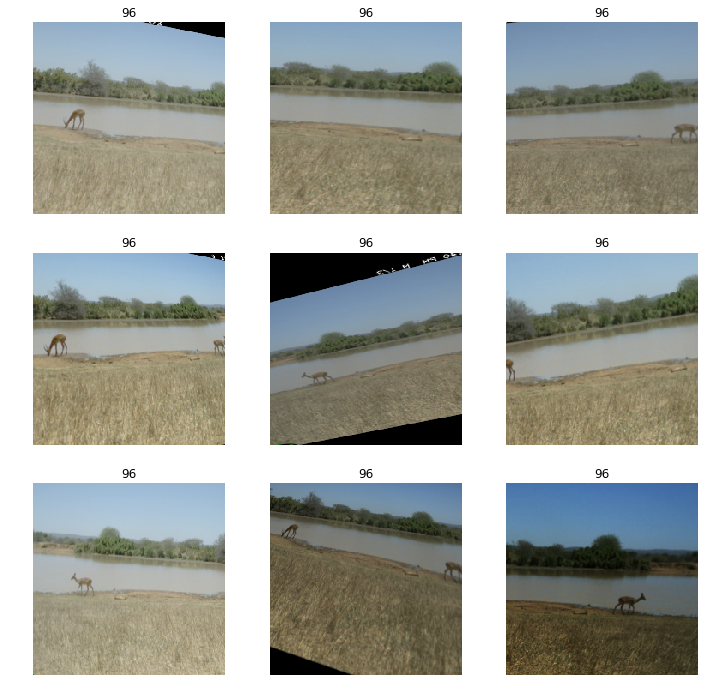

In [20]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(12,12))

# Train Model

In [21]:
!ls /kaggle/working/

__notebook__.ipynb


In [22]:
gc.collect()
wd=1e-2
#learn = cnn_learner(data, models.densenet121, metrics=error_rate, bn_final=True, wd=wd )
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True, wd=wd )
learn.model_dir= '/kaggle/working/'

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [23]:
data = get_data(352,bs)
learn.data = data
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-4))
learn.save('352')

epoch,train_loss,valid_loss,error_rate,time
0,5.077619,4.570718,0.868194,38:04
1,4.538859,4.042492,0.721883,37:52
2,4.232742,3.783232,0.625648,37:58
3,4.039329,3.626547,0.569011,38:00
4,3.924613,3.608983,0.555197,37:42
5,3.882832,3.569298,0.535628,37:42


In [24]:
learn.unfreeze()

In [25]:
lr = 1e-3
learn.fit_one_cycle(4, slice(lr/100, lr))

epoch,train_loss,valid_loss,error_rate,time
0,3.282751,2.565688,0.390066,38:15
1,2.613632,2.037313,0.326580,38:13
2,2.249493,1.748748,0.291010,38:11
3,2.067406,1.720903,0.278980,38:10


# interpretation

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [27]:
# %%time
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Test Predictions

In [28]:
test_preds = learn.get_preds(DatasetType.Test)
df_test['Category'] = test_preds[0].argmax(dim=1)

In [29]:
df_test.head()

,seq_num_frames,location,datetime,image_id,frame_num,seq_id,width,height,file_name,Category
0,1,84,2013-08-02 21:44:00.000,88037cce-21bc-11ea-a13a-137349068a90,1,88037e90-21bc-11ea-a13a-137349068a90,2771,1779,88037cce-21bc-11ea-a13a-137349068a90.jpg,117
1,1,84,2013-08-02 21:51:00.000,963e6b46-21bc-11ea-a13a-137349068a90,1,963e6cb8-21bc-11ea-a13a-137349068a90,2771,1779,963e6b46-21bc-11ea-a13a-137349068a90.jpg,117
2,1,548,2013-04-25 18:23:00.000,8a1b53ba-21bc-11ea-a13a-137349068a90,1,8a1b5554-21bc-11ea-a13a-137349068a90,2895,1865,8a1b53ba-21bc-11ea-a13a-137349068a90.jpg,0
3,1,181,2013-04-17 16:10:00.000,938c0d5e-21bc-11ea-a13a-137349068a90,1,938c0f02-21bc-11ea-a13a-137349068a90,2902,1818,938c0d5e-21bc-11ea-a13a-137349068a90.jpg,51
4,1,181,2013-04-20 03:11:00.000,95b9bd92-21bc-11ea-a13a-137349068a90,1,95b9be96-21bc-11ea-a13a-137349068a90,2212,1841,95b9bd92-21bc-11ea-a13a-137349068a90.jpg,8


In [30]:
df_test = df_test.rename(columns={"image_id": "Id"})
df_test = df_test.drop(['seq_num_frames', 'location', 'datetime', 'frame_num', 'seq_id', 'width', 'height', 'file_name'], axis=1)

In [31]:
submission = pd.read_csv('/kaggle/input/iwildcam-2020-fgvc7/sample_submission.csv')
submission = submission.drop(['Category'], axis=1)
submission = submission.merge(df_test, on='Id')
submission.to_csv('submission.csv', index=False)